# Logistic Regression Hyperparameter Tuning using FPGAs

This notebook shows how to train and apply many accelerated sklearn models, with a k-fold cross validation and hyperparameter tuning step.

In [1]:
from inaccel.sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression as LogisticRegressionCPU
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from time import time
import matplotlib.pyplot as plt
import numpy as np
import random
import warnings

warnings.filterwarnings('ignore')

For this example we'll be using the Modified NIST (*National Institute of Standards and Technology*) Digits dataset which is a set of **handwritten digits** derived from the NIST Special Database 19 and converted to a 28x28 pixel grayscale image format. Further information on the dataset's contents and conversion process is available at https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html#mnist8m.
Begin by featching the data from openml and inspecting the schema.
<center>
<img src="../img/digits.png" />
</center>

In [2]:
X, y = fetch_openml('mnist_784', return_X_y = True)

features = StandardScaler()
X = features.fit_transform(X)

label = LabelEncoder()
y = label.fit_transform(y)

print("Data shape:\tLabels: " + str(y.shape) + "\tFeatures: " + str(X.shape))

Data shape:	Labels: (70000,)	Features: (70000, 784)


| Grid of Hyperparameters |
| ----------------------- |
---

In [3]:
param_grid = {
        'max_iter': (50, 100),
        'l1_ratio': (0.3, 0.9),
}

| FPGA Accelerated GridSearchCV |
| ----------------------------- |
---

In [4]:
lr = LogisticRegression(n_accel=4)

grid_search = GridSearchCV(lr, param_grid, scoring='accuracy', verbose=1, cv=3, n_jobs=4, pre_dispatch = '4 * n_jobs')

In [5]:
start_time = time()
grid_search.fit(X, y)
elapsed_time = int((time() - start_time) * 100) / 100

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [6]:
print("done in {0}s".format(elapsed_time))
print("Best score: {0}".format(grid_search.best_score_))

print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(list(param_grid.keys())):
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

done in 31.45s
Best score: 0.9166571864959714
Best parameters set:
	l1_ratio: 0.3
	max_iter: 100


### Evaluating Logistic Regression
In the next cell we validate the trained model using the produced coefficients to visualize its classes.

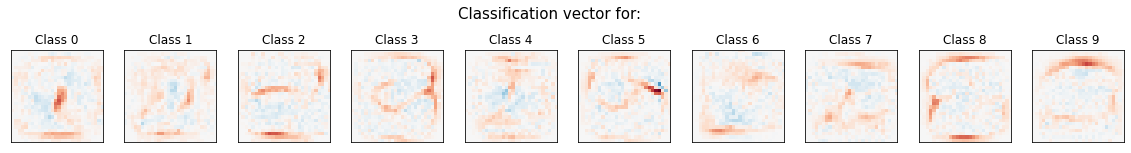

In [7]:
coef = grid_search.best_estimator_.coef_.copy()
plt.figure(figsize=(20, 20))
plt.suptitle('Classification vector for:', y=0.91, fontsize = 15)
scale = np.abs(coef).max()
for i in range(len(np.unique(y))):
    fig = plt.subplot(10, 10, i + 1)
    fig.imshow(coef[i].reshape(28, 28), cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    fig.set_xticks(())
    fig.set_yticks(())
    fig.set_title('Class %i' % i)


|CPU GridSearchCV |
| --------------- |
---

In [8]:
lrCPU = LogisticRegressionCPU(intercept_scaling=0)

grid_searchCPU = GridSearchCV(lrCPU, param_grid, scoring='accuracy', verbose=1, cv=3, n_jobs=4, pre_dispatch = '4 * n_jobs')

In [9]:
start_timeCPU = time()
grid_searchCPU.fit(X, y) 
elapsed_timeCPU = int((time() - start_timeCPU) * 100) / 100

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [10]:
print("done in {0}s".format(elapsed_timeCPU))  
print("Best score: {0}".format(grid_searchCPU.best_score_))  
print("Best parameters set:")  
best_parameters = grid_searchCPU.best_estimator_.get_params()  
for param_name in sorted(list(param_grid.keys())):  
    print("\t{0}: {1}".format(param_name, best_parameters[param_name]))

done in 195.02s
Best score: 0.916428611802047
Best parameters set:
	l1_ratio: 0.3
	max_iter: 50


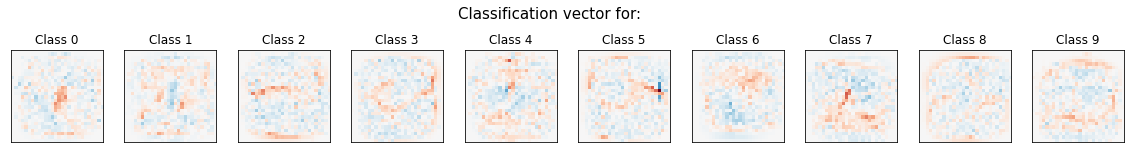

In [11]:
coef = grid_searchCPU.best_estimator_.coef_.copy()
plt.figure(figsize=(20, 20))
plt.suptitle('Classification vector for:', y=0.91, fontsize = 15)
scale = np.abs(coef).max()
for i in range(len(np.unique(y))):
    fig = plt.subplot(10, 10, i + 1)
    fig.imshow(coef[i].reshape(28, 28), cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    fig.set_xticks(())
    fig.set_yticks(())
    fig.set_title('Class %i' % i)

| Speedup Calculation |
|---------------------|
---

In [12]:
speedup = int(elapsed_timeCPU / elapsed_time * 100) / 100
print("Speedup: " + str(speedup))

Speedup: 6.2
